# Tunnel diode model nonlinearity approximator

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import place_poles
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [53]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 12
})

## Tunnel diode model

In [27]:
# Parameters with time in ns
Cap = 2 #Capacity in pF
L = 5 # uH
R = 1.5 # kOhm

# State-space matrices
A = np.array([[0, 1/Cap],
              [-1/L, -R/L]])
B = np.array([[0],
              [1/L]])
C = np.array([[1.0, 0.0]])
F = np.array([[1.0], # коэффициент -1/Cap внесем в нелинейность
              [0]])
dt = 0.1

def nonlinearity(y):
    return np.array(-1/Cap * (
        17.76*y +-103.79*np.power(y, 2) + 229.62*np.power(y, 3) - 226.31*np.power(y, 4) + 83.72*np.power(y, 5)))\
            .reshape(-1, 1)

def diode_dynamics(x, u):
    dx = A @ x + B * u + F * nonlinearity(x[0])
    return x + dx * dt

def linear_dynamics(x, u):
    dx = A @ x + B * u
    return x + dx * dt

## Dataset generation

In [40]:
n_simulations  = 100
dt = 0.01
startTime = 0
endTime = 5
n_steps = int((endTime - startTime) / dt)

x_history = np.zeros((n_steps, A.shape[0]))
y_history = np.zeros((n_steps, C.shape[0]))
x_lin_history = np.zeros((n_steps, A.shape[0]))
y_lin_history = np.zeros((n_steps, C.shape[0]))

data = []
for _ in range(n_simulations):
    u_history = np.ones((n_steps, 1)) * np.random.uniform(-10, 10)
    x0 = np.random.uniform(-0.9, 0.9, size=(2, 1))
    x = x0
    for step in range(n_steps):
        u = u_history[step]
        x_old = x.copy()
        y_old = C @ x_old
        x = diode_dynamics(x, u)
        y = C @ x #+ 0.0005 * np.random.randn()
        bar_x = linear_dynamics(x_old, u_history[step])
        bar_y = C @ bar_x
        target = (y - bar_y) / dt
        data.append(np.vstack([u, y_old, target]).T)  
data = np.vstack(data)    
X = data[:, 1].reshape(-1, 1) # только y
y = data[:, -1].reshape(-1, 1) # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.shape, y_train.shape

((37500, 1), (37500, 1))

## Approximator

In [41]:
class NonlinearityApproximator:
    def __init__(self, hidden_size: int = 32, num_layers: int = 2, learning_rate: float = 0.001) -> None:
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        
        self.model = self._create_network()
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=5, factor=0.5)
        self.x_scaler = StandardScaler()
        self.y_scaler = StandardScaler()
  
    def _create_network(self) -> nn.Module:
        layers = []
        # Входной слой
        layers.append(nn.Linear(1, self.hidden_size))
        layers.append(nn.Tanh())        
        # Скрытые слои
        for _ in range(self.num_layers - 1):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(nn.Tanh())        
        # Выходной слой
        layers.append(nn.Linear(self.hidden_size, 1))        
        return nn.Sequential(*layers)
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray,
            n_epochs: int = 1000, batch_size: int = 64) -> 'NonlinearityApproximator':
        X_scaled = self.x_scaler.fit_transform(X_train)
        y_scaled = self.y_scaler.fit_transform(y_train)
        train_dataset = TensorDataset(torch.FloatTensor(X_scaled), 
                                          torch.FloatTensor(y_scaled))
        train_loader = DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)
        X_val_scaled = self.x_scaler.transform(X_val)
        y_val_scaled = self.y_scaler.transform(y_val)
        val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), 
                                          torch.FloatTensor(y_val_scaled))
        val_loader = DataLoader(val_dataset,
                                      batch_size=batch_size,
                                      shuffle=True)
        
        epoch_train_losses = []
        epoch_val_losses = []
            
        self.model.train()
        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(batch_X)
                loss = self.criterion(y_pred, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            epoch_train_losses.append(avg_loss)
            epoch_val_loss = 0.0
            for batch_X, batch_y in val_loader:
                y_pred = self.model(batch_X)
                loss = self.criterion(y_pred, batch_y)
                epoch_val_loss += loss.item()
            avg_val_loss = epoch_loss / len(val_loader)
            epoch_val_losses.append(avg_val_loss)                
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {avg_loss:.6f}, LR: {self.optimizer.param_groups[0]["lr"]:.6f}')  
        return epoch_train_losses, epoch_val_losses                 


    def predict(self, X: np.ndarray) -> np.ndarray:
        with torch.no_grad():
            X_scaled = self.x_scaler.transform(X)
            X_tensor = torch.Tensor(X_scaled)
            y_scaled = self.model(X_tensor)
            y_pred = self.y_scaler.inverse_transform(y_scaled.numpy())
            return y_pred.ravel()
    
    def save(self, path: str) -> None:
        """Сохранение модели"""
        try:
            state = {
                'model_state': self.model.state_dict(),
                'x_scaler': self.x_scaler,
                'y_scaler': self.y_scaler,
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'learning_rate': self.learning_rate,
            }
            torch.save(state, path)
            print(f'Модель сохранена в {path}')
        except Exception as e:
            print(f'Ошибка при сохранении модели: {e}')
            raise
    
    def load(self, path: str) -> 'NonlinearityApproximator':
        try:
            state = torch.load(path)
            self.hidden_size = state['hidden_size']
            self.num_layers = state['num_layers']
            self.learning_rate = state['learning_rate']
            self.model = self._create_network()
            self.model.load_state_dict(state['model_state'])
            self.x_scaler = state['x_scaler']
            self.y_scaler = state['y_scaler']
            self.is_fitted = state['is_fitted']
            print(f'Модель загружена из {path}')
            return self
        except Exception as e:
            print(f'Ошибка при загрузке модели: {e}')
            raise

In [54]:
approximator = NonlinearityApproximator()
n_epochs = 200
train_losses, val_losses = approximator.fit(X_train, y_train, X_test, y_test, n_epochs=n_epochs)
y_list = np.linspace(-0.5, 0.5, 100)
u_list = np.ones([y_list.shape[0], 1])
f_list = []
f_pred_list = []
for i in range(y_list.shape[0]):
    f = nonlinearity(y_list[i])
    f_list.append(f)
f_list = np.array(f_list).ravel()
f_pred_list = approximator.predict(y_list.reshape(-1, 1))   


Epoch [100/200], Loss: 0.003090, LR: 0.001000
Epoch [200/200], Loss: 0.001170, LR: 0.001000


In [44]:
approximator.save('nonlinearity_model.pth')

Модель сохранена в nonlinearity_model.pth


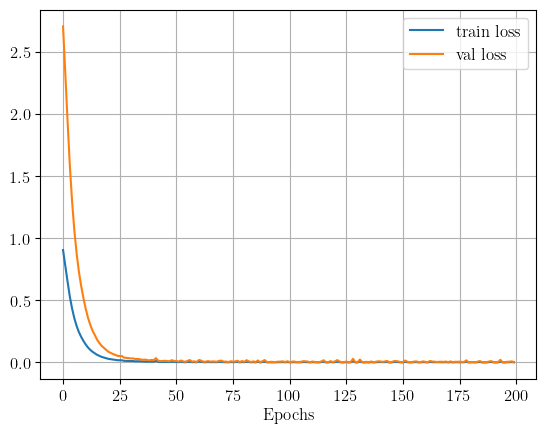

In [78]:
plt.plot(range(n_epochs), train_losses, label='train loss')
plt.plot(range(n_epochs), val_losses, label='val loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.savefig('train_losses.png')

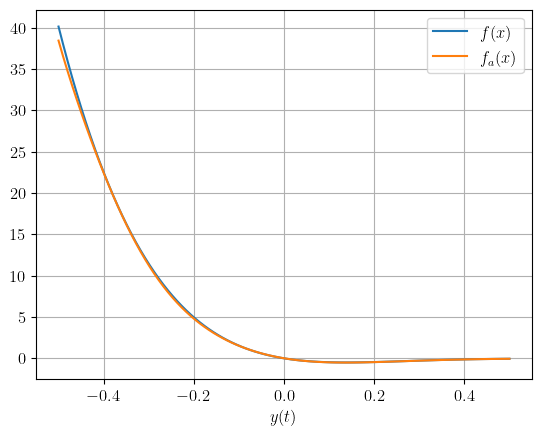

In [79]:
plt.plot(y_list, f_list, label='$f(x)$')
plt.plot(y_list, f_pred_list, label='$f_a(x)$')
plt.xlabel('$y(t)$')
plt.grid()
plt.legend()
plt.savefig('approximation.png')

## Model testing

In [64]:
def approx_dynamics(x, u):
    y = C @ x
    f_pred = approximator.predict(y)
    dx = A @ x + B * u + F * f_pred
    return x + dx * dt

In [65]:
startTime = 0
endTime = 10
n_steps = int((endTime - startTime) / dt)
u_history = np.ones((n_steps, 1)) *1
noise =  0.0005 * np.random.randn(n_steps, 1)
x0 = np.array([[0.0],
               [0.0]])
#  Нелинейная модель
y1_history = np.zeros((n_steps, C.shape[0]))
x = x0
for step in range(n_steps):
    y = C @ x + noise[step]
    y1_history[step] = y 
    x = diode_dynamics(x, u_history[step])    

# Модель с аппроксиматором    
y3_history = np.zeros((n_steps, C.shape[0]))
x = x0
for step in range(n_steps):
    y = C @ x  
    y3_history[step] = y
    x = approx_dynamics(x, u_history[step])    

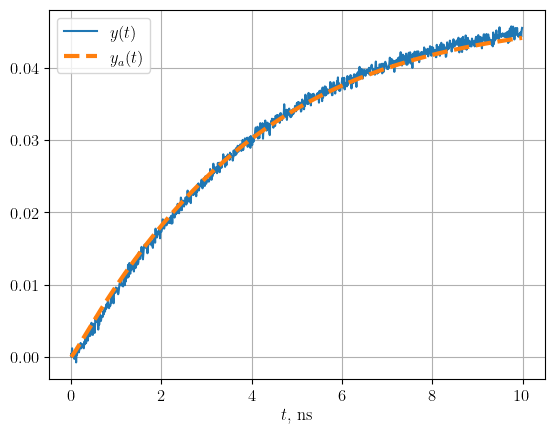

In [82]:
plt.plot(np.arange(startTime, endTime, dt), y1_history, label='$y(t)$')
plt.plot(np.arange(startTime, endTime, dt), y3_history, '--', label='$y_a(t)$', linewidth=3)
plt.xlabel('$t$, ns')
plt.grid()
plt.legend()
plt.savefig('plant_with_approximator.png')